In [6]:
import networkx as nx

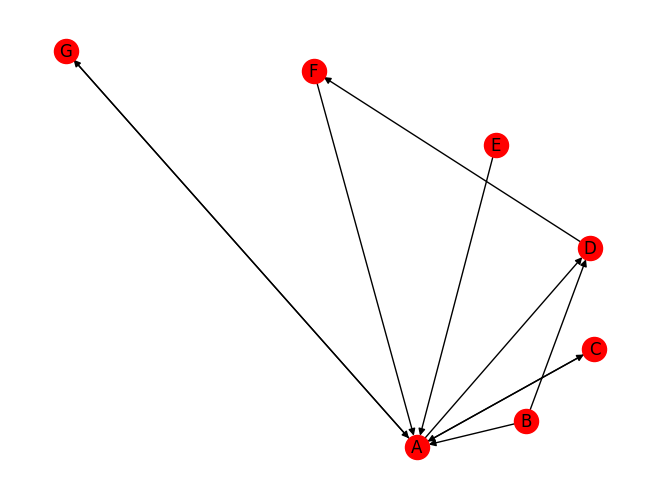

In [334]:
G = nx.DiGraph()

[G.add_node(k) for k in ["A", "B", "C", "D", "E", "F", "G"]]
G.add_edges_from([('G','A'), ('A','G'),('B','A'),
                  ('C','A'),('A','C'),('A','D'),
                  ('E','A'),('F','A'),('B','D'),
                  ('D','F')])
pos = nx.spiral_layout(G)
nx.draw(G, pos, with_labels = True, node_color="red")

In [335]:
alpha = 0.85
weight = 1
max_iter = 100
W = nx.stochastic_graph(G,copy='true', weight=weight)
N = W.number_of_nodes()
x = dict.fromkeys(W, 1.0 / N)
p = dict.fromkeys(W, 1.0 / N)
dangling_weights = p
dangling_nodes = [n for n in W if W.out_degree(n, weight=weight) == 0.0]
print(x)

{'A': 0.14285714285714285, 'B': 0.14285714285714285, 'C': 0.14285714285714285, 'D': 0.14285714285714285, 'E': 0.14285714285714285, 'F': 0.14285714285714285, 'G': 0.14285714285714285}


In [ ]:
xlast = x
print('X = ', x)

x = dict.fromkeys(xlast.keys(), 0)
print('X = ', x)
for n in x:
  print('n = ', n)
  print('W[n] = ',W[n])
  for nbr in W[n]:
    print('nbr = ', nbr)
    print("xlast[",n, "] = ", xlast[n])
    print('W[',n,'][',nbr,'][', weight,']=', W[n][nbr][weight])
    x[nbr] += alpha * xlast[n] * W[n][nbr][weight]
    print("x[",nbr,"] = ",x[nbr])
  x[n] += danglesum * dangling_weights[n] + (1.0 - alpha) * p[n]
  print("this round")
  print("x[",n,"] = ",x[n])
  print('\n')
x

In [135]:
for _ in range(max_iter):
  xlast = x
  x = dict.fromkeys(xlast.keys(), 0)
  danglesum = alpha * sum(xlast[n] for n in dangling_nodes)
  for n in x:
    for nbr in W[n]:
      x[nbr] += alpha * xlast[n] * W[n][nbr][weight]
    x[n] += danglesum * dangling_weights[n] + (1.0 - alpha) * p[n]


In [136]:
dict(sorted(x.items(), key=lambda item: item[1]),reverse = "true")

{'B': 0.021428571428571432,
 'E': 0.021428571428571432,
 'C': 0.13476634117178157,
 'G': 0.13476634117178157,
 'F': 0.14372103285315715,
 'D': 0.14387348402892441,
 'A': 0.4000156579172122,
 'reverse': 'true'}

In [2]:
def pagerank(G, alpha=0.85, personalization=None,
			max_iter=100, tol=1.0e-6, nstart=None, weight='weight',
			dangling=None):

	if len(G) == 0:
		return {}

	if not G.is_directed():
		D = G.to_directed()
	else:
		D = G

	# Create a copy in (right) stochastic form
	W = nx.stochastic_graph(D, weight=weight)
	N = W.number_of_nodes()

	# Choose fixed starting vector if not given
	if nstart is None:
		x = dict.fromkeys(W, 1.0 / N)
	else:
		# Normalized nstart vector
		s = float(sum(nstart.values()))
		x = dict((k, v / s) for k, v in nstart.items())

	if personalization is None:

		# Assign uniform personalization vector if not given
		p = dict.fromkeys(W, 1.0 / N)
	else:
		missing = set(G) - set(personalization)
		if missing:
			raise NetworkXError('Personalization dictionary '
								'must have a value for every node. '
								'Missing nodes %s' % missing)
		s = float(sum(personalization.values()))
		p = dict((k, v / s) for k, v in personalization.items())

	if dangling is None:

		# Use personalization vector if dangling vector not specified
		dangling_weights = p
	else:
		missing = set(G) - set(dangling)
		if missing:
			raise NetworkXError('Dangling node dictionary '
								'must have a value for every node. '
								'Missing nodes %s' % missing)
		s = float(sum(dangling.values()))
		dangling_weights = dict((k, v/s) for k, v in dangling.items())
	dangling_nodes = [n for n in W if W.out_degree(n, weight=weight) == 0.0]

	# power iteration: make up to max_iter iterations
	for _ in range(max_iter):
		xlast = x
		x = dict.fromkeys(xlast.keys(), 0)
		danglesum = alpha * sum(xlast[n] for n in dangling_nodes)
		for n in x:

			# this matrix multiply looks odd because it is
			# doing a left multiply x^T=xlast^T*W
			for nbr in W[n]:
				x[nbr] += alpha * xlast[n] * W[n][nbr][weight]
			x[n] += danglesum * dangling_weights[n] + (1.0 - alpha) * p[n]

		# check convergence, l1 norm
		err = sum([abs(x[n] - xlast[n]) for n in x])
		if err < N*tol:
			return x
	raise NetworkXError('pagerank: power iteration failed to converge '
						'in %d iterations.' % max_iter)


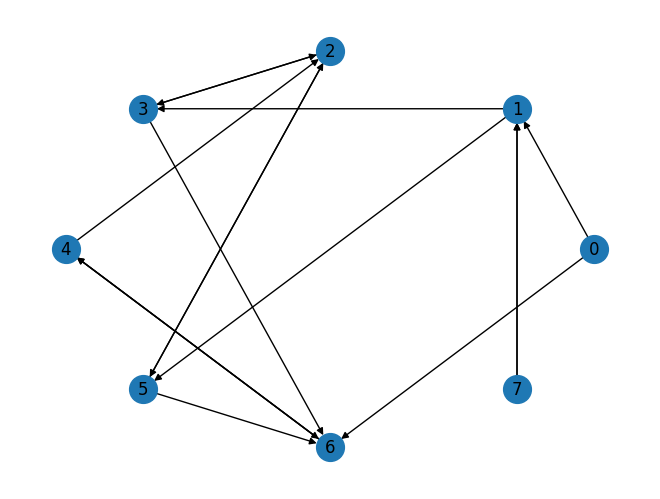

In [444]:
###pagrRank in numpy
import numpy as np
D = nx.random_k_out_graph(n = 8,k = 2,alpha = 0.75)
# D.remove_edges_from(nx.selfloop_edges(G))
def draw(G):
  nx.draw_circular(G,node_size = 400, with_labels = True)
draw(D)

In [445]:
from collections import Counter

def flip(p):
  return np.random.random() < p

def random_walk(G, alpha=0.5, iters=10000):
    counter = Counter()
    node =  np.random.choice(list(G))

    for _ in range(iters):
        if flip(alpha):
            node = np.random.choice(list(G[node]))

        else:
            node = np.random.choice(list(G))
        counter[node] += 1

    total = sum(counter.values())
    for key in counter:
        counter[key] /= total
    return counter

rw = random_walk(D)
sorted(rw.items() , key = lambda item : item[1])

[(7, 0.0603),
 (0, 0.0642),
 (1, 0.1109),
 (5, 0.1295),
 (3, 0.1307),
 (4, 0.1536),
 (2, 0.1664),
 (6, 0.1844)]

In [447]:
prr = nx.pagerank(D)
sorted(prr.items() , key = lambda item : item[1])

[(0, 0.018750000000000003),
 (7, 0.018750000000000003),
 (1, 0.04265625000000001),
 (3, 0.1302178331657264),
 (5, 0.1302178331657264),
 (4, 0.21220129133145282),
 (2, 0.21961902116854715),
 (6, 0.22758777116854717)]

In [ ]:
#matrix version
#https://allendowney.github.io/DSIRP/pagerank.html

In [448]:
M = nx.to_numpy_array(D)
M /= M.sum(axis=1)
M


array([[0. , 0.5, 0. , 0. , 0. , 0. , 0.5, 0. ],
       [0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. ],
       [0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. ],
       [0. , 0. , 0.5, 0. , 0. , 0. , 0.5, 0. ],
       [0. , 0. , 0.5, 0. , 0. , 0. , 0.5, 0. ],
       [0. , 0. , 0.5, 0. , 0. , 0. , 0.5, 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. ]])

In [449]:
N = len(D)
x = np.full(N,100)
x

array([100, 100, 100, 100, 100, 100, 100, 100])

In [ ]:
print(np.shape(M.T))
print(np.shape(x))


In [455]:
x = M.T @ x
x

array([  0.,   0., 150., 125., 250., 125., 150.,   0.])

In [460]:
p = np.full((N, N), 1/N)
p

array([[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
       [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
       [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
       [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
       [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
       [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
       [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
       [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]])

In [462]:
alpha = 0.85
GM = alpha * M + (1 - alpha) * p
GM

array([[0.01875, 0.44375, 0.01875, 0.01875, 0.01875, 0.01875, 0.44375,
        0.01875],
       [0.01875, 0.01875, 0.01875, 0.44375, 0.01875, 0.44375, 0.01875,
        0.01875],
       [0.01875, 0.01875, 0.01875, 0.44375, 0.01875, 0.44375, 0.01875,
        0.01875],
       [0.01875, 0.01875, 0.44375, 0.01875, 0.01875, 0.01875, 0.44375,
        0.01875],
       [0.01875, 0.01875, 0.44375, 0.01875, 0.01875, 0.01875, 0.44375,
        0.01875],
       [0.01875, 0.01875, 0.44375, 0.01875, 0.01875, 0.01875, 0.44375,
        0.01875],
       [0.01875, 0.01875, 0.01875, 0.01875, 0.86875, 0.01875, 0.01875,
        0.01875],
       [0.01875, 0.86875, 0.01875, 0.01875, 0.01875, 0.01875, 0.01875,
        0.01875]])

In [464]:
x = np.full(N, 100)

for _ in range(100):
    x = GM.T @ x

In [481]:
ranks_am = x / x.sum()
ranks_am = list(ranks_am)
a = [0,1,2,3,4,5,6,7]
d = zip(a,ranks_am)
rank_am = dict(d)
sorted(rank_am.items() , key = lambda item : item[1])

[(0, 0.018750000000000003),
 (7, 0.018750000000000003),
 (1, 0.04265625000000001),
 (3, 0.13021738004578465),
 (5, 0.13021738004578465),
 (4, 0.21220038509156935),
 (2, 0.2196199274084307),
 (6, 0.2275886774084307)]